# NB02: Module Families and Core Genome

Do cross-organism module families map to the core genome?
Families that span more organisms should contain more core genes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path

FAMILY_DIR = Path('../../fitness_modules/data/module_families')
CONS_DIR = Path('../../conservation_vs_fitness/data')
DATA_DIR = Path('../data')
FIGURES_DIR = Path('../figures')

# Load module conservation from NB01
module_cons = pd.read_csv(DATA_DIR / 'module_conservation.tsv', sep='\t')

# Load module families
families = pd.read_csv(FAMILY_DIR / 'module_families.csv')
family_annot = pd.read_csv(FAMILY_DIR / 'family_annotations.csv')

# Load essential genes
essential = pd.read_csv(CONS_DIR / 'essential_genes.tsv', sep='\t', low_memory=False)
essential = essential[(essential['orgId'] != 'Dyella79') & (essential['is_essential'])]

print(f'Module conservation: {len(module_cons)} modules')
print(f'Module families: {families["familyId"].nunique()} families, {len(families)} module assignments')
print(f'Family annotations: {len(family_annot)} families')

Module conservation: 1008 modules
Module families: 749 families, 1114 module assignments
Family annotations: 156 families


## Step 1: Family Conservation Profiles

In [2]:
# Join families with module conservation
fam_cons = families.merge(module_cons, on=['orgId', 'module'], how='inner')

# Document dropped families
n_all_families = families['familyId'].nunique()
n_matched_families = fam_cons['familyId'].nunique()
n_dropped = n_all_families - n_matched_families
print(f'Family-module pairs with conservation data: {len(fam_cons)}')
print(f'Families matched: {n_matched_families} / {n_all_families} ({n_dropped} dropped)')
print(f'  Dropped families had no modules in the 29 overlapping organisms')

# Per-family aggregation
family_summary = fam_cons.groupby('familyId').agg(
    n_modules_obs=('module', 'size'),
    n_organisms_obs=('orgId', 'nunique'),
    total_genes=('n_genes', 'sum'),
    total_core=('n_core', 'sum'),
    total_mapped=('n_mapped', 'sum'),
    mean_pct_core=('pct_core', 'mean'),
).reset_index()

family_summary['overall_pct_core'] = (family_summary['total_core'] / family_summary['total_mapped'] * 100).round(1)

# Merge family annotations — use suffixes to avoid collision
family_summary = family_summary.merge(family_annot, on='familyId', how='left',
                                       suffixes=('_obs', '_annot'))

print(f'\nFamilies with conservation data: {len(family_summary)}')
print(f'Mean family % core: {family_summary["overall_pct_core"].mean():.1f}%')

# Save
family_summary.to_csv(DATA_DIR / 'family_conservation.tsv', sep='\t', index=False)

Family-module pairs with conservation data: 1006
Families matched: 688 / 749 (61 dropped)
  Dropped families had no modules in the 29 overlapping organisms

Families with conservation data: 688
Mean family % core: 85.2%


## Step 2: Family Breadth vs Conservation

/tmp/ipykernel_128528/1251435156.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([d for d, _ in bin_data_present],


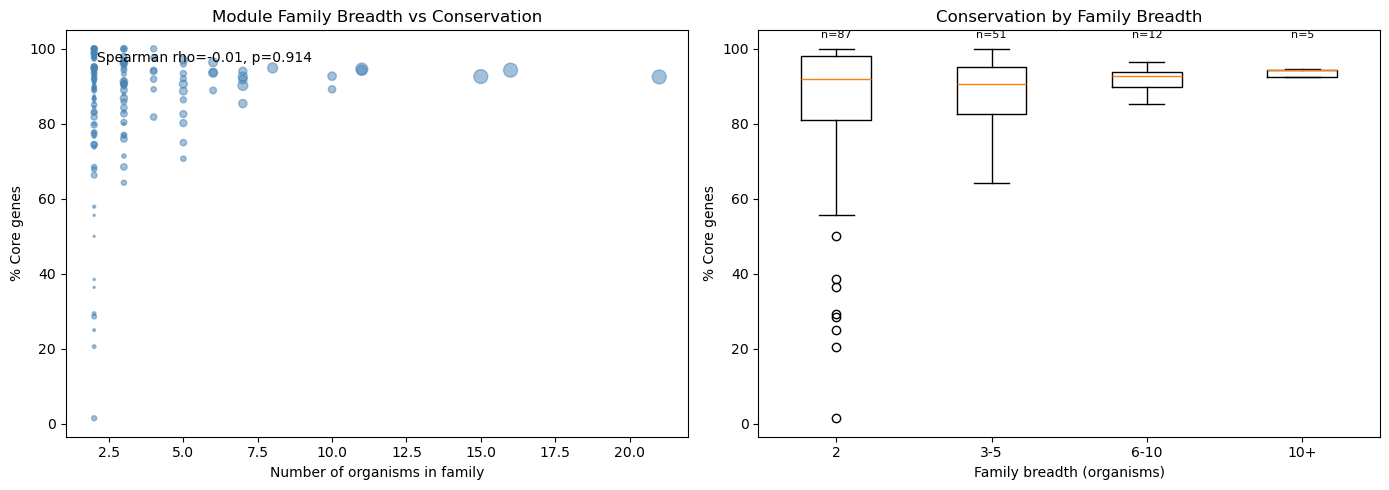

Spearman rho=-0.01, p=0.914


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Use n_organisms from family_annot (original count, not our 29-org subset)
fs = family_summary[family_summary['total_mapped'] >= 5].copy()
fs = fs.dropna(subset=['n_organisms', 'overall_pct_core'])

axes[0].scatter(fs['n_organisms'], fs['overall_pct_core'],
                s=fs['total_genes'].clip(10, 500) / 5, alpha=0.5, color='steelblue')
axes[0].set_xlabel('Number of organisms in family')
axes[0].set_ylabel('% Core genes')
axes[0].set_title('Module Family Breadth vs Conservation')

rho, pval = stats.spearmanr(fs['n_organisms'], fs['overall_pct_core'])
axes[0].text(0.05, 0.95, f'Spearman rho={rho:.2f}, p={pval:.3f}',
             transform=axes[0].transAxes, fontsize=10, va='top')

# Box plot: binned by n_organisms
bins = [0, 2, 5, 10, 100]
labels = ['2', '3-5', '6-10', '10+']
fs['breadth_bin'] = pd.cut(fs['n_organisms'], bins=bins, labels=labels)

bin_data_present = [(fs[fs['breadth_bin'] == lbl]['overall_pct_core'].values, lbl)
                     for lbl in labels
                     if len(fs[fs['breadth_bin'] == lbl]) > 0]

if bin_data_present:
    axes[1].boxplot([d for d, _ in bin_data_present],
                    labels=[lbl for _, lbl in bin_data_present])
    axes[1].set_xlabel('Family breadth (organisms)')
    axes[1].set_ylabel('% Core genes')
    axes[1].set_title('Conservation by Family Breadth')

    for i, (d, lbl) in enumerate(bin_data_present):
        axes[1].text(i + 1, 103, f'n={len(d)}', ha='center', fontsize=8)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'family_breadth_vs_conservation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Spearman rho={rho:.2f}, p={pval:.3f}')

## Step 3: Which Families Are Accessory?

In [4]:
# Families with low core fraction
accessory_fams = family_summary[family_summary['overall_pct_core'] < 50].sort_values('overall_pct_core')
core_fams = family_summary[family_summary['overall_pct_core'] >= 90].sort_values('overall_pct_core', ascending=False)

print(f'=== ACCESSORY FAMILIES (<50% core, n={len(accessory_fams)}) ===')
if len(accessory_fams) > 0:
    cols = ['familyId', 'n_organisms', 'total_genes', 'overall_pct_core', 'consensus_term', 'consensus_db']
    display_cols = [c for c in cols if c in accessory_fams.columns]
    print(accessory_fams[display_cols].head(20).to_string(index=False))

print(f'\n=== CORE FAMILIES (>=90% core, n={len(core_fams)}) ===')
if len(core_fams) > 0:
    print(core_fams[display_cols].head(20).to_string(index=False))

=== ACCESSORY FAMILIES (<50% core, n=38) ===
familyId  n_organisms  total_genes  overall_pct_core consensus_term consensus_db
    F054          NaN           17               0.0            NaN          NaN
    F151          NaN           45               0.0            NaN          NaN
    F193          NaN           26               0.0            NaN          NaN
    F253          NaN           48               0.0            NaN          NaN
    F236          NaN           41               0.0            NaN          NaN
    F665          NaN           50               0.0            NaN          NaN
    F001          2.0           67               1.5        PF05136         PFam
    F088          NaN            8              12.5            NaN          NaN
    F481          NaN           15              13.3            NaN          NaN
    F514          NaN           50              14.3            NaN          NaN
    F147          NaN           50              15.9            

## Step 4: Essential Genes in Modules

In [5]:
# Load all module membership to check if any essential genes are in modules
import os

MODULE_DIR = Path('../../fitness_modules/data/modules')
overlap_orgs = sorted(set(f.replace('_gene_membership.csv', '')
                          for f in os.listdir(MODULE_DIR)
                          if f.endswith('_gene_membership.csv'))
                      & set(essential['orgId'].unique()))

module_loci = set()
for orgId in overlap_orgs:
    mem = pd.read_csv(MODULE_DIR / f'{orgId}_gene_membership.csv')
    module_cols = [c for c in mem.columns if c.startswith('M')]
    in_module = mem[mem[module_cols].sum(axis=1) > 0]
    for lid in in_module['locusId'].astype(str):
        module_loci.add((orgId, lid))

# How many essential genes are in modules?
ess_loci = set(zip(essential['orgId'], essential['locusId'].astype(str)))
ess_in_modules = ess_loci & module_loci

print(f'Essential genes: {len(ess_loci):,}')
print(f'Genes in modules: {len(module_loci):,}')
print(f'Essential genes IN modules: {len(ess_in_modules)}')
print(f'\nAs expected, this should be ~0 because ICA requires fitness data')
print(f'and essential genes have no fitness data (no transposon insertions).')

if len(ess_in_modules) > 0:
    print(f'\nSurprise: {len(ess_in_modules)} essential genes found in modules!')
    print('These may be genes at the boundary of essentiality.')

Essential genes: 27,693
Genes in modules: 19,824
Essential genes IN modules: 0

As expected, this should be ~0 because ICA requires fitness data
and essential genes have no fitness data (no transposon insertions).


In [6]:
print('=' * 60)
print('NB02 SUMMARY: Module Families and Core Genome')
print('=' * 60)
print(f'Families analyzed: {len(family_summary)}')
print(f'Mean family % core: {family_summary["overall_pct_core"].mean():.1f}%')
print(f'Breadth-conservation Spearman: rho={rho:.2f}, p={pval:.3f}')
print(f'Accessory families (<50% core): {len(accessory_fams)}')
print(f'Core families (>=90% core): {len(core_fams)}')
print(f'Essential genes in modules: {len(ess_in_modules)}')
print('=' * 60)

NB02 SUMMARY: Module Families and Core Genome
Families analyzed: 688
Mean family % core: 85.2%
Breadth-conservation Spearman: rho=-0.01, p=0.914
Accessory families (<50% core): 38
Core families (>=90% core): 374
Essential genes in modules: 0
